In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-malignant-vs-benign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174469%2F505351%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T212418Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0023532e4aae750e26a6ff118e1838a446903883fe38e66068ca6a90c2d233b0af929c02971d368fd4919716ad365fb9162b202127d58a25eaf88692cdc5ff89167897ad9e8ffdc0dbf3008d4bd2ffe530bd29112a713fe11547706f3bef83613e42e162d7a2d704eb5e9bdfb1e0f48021b60a538426bdc820de1182fc52dc2d9032765bd2a740173f8b2564acb557d98cbfd67a44c0610ca18460f4e1761f1b0a5df5d83d8f9a200247456c3281b3e565dc4e393ab2566a66aba1126387d275d3b8fb7e9f5d0e7783b9f6e8e574797669a8e73472ab14dc69a69f31d546ffb3a00b7e1d6939fb1024dabc751e8fda2f3411eb57f86798f9add3c549ddc2eb15,prediction-file:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4906083%2F8264828%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T212418Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D848ff19ee0129b3f716bf49267dbc81fc6b487beefe772ada90d360865fa800771e8dc0db48ee162f051218835f335892129cd79de799c41bb924db9da12dcb4edb141003fbd3344f264f3381c9d3e38752a1f0d6ae9c12a7fa8497e66629d2e50e9959028d174e50307b6630da57cd9b49af2023cd94908e14b707a88f2863d16274c0fe1e787cf36b86609275e1a60ef18e3bf1771a961e70da97815fdea7775d2293c6f2d653b588a8d6d2f810ed329bbb49edb6b9b4d13bd80f7a4c842d91f503416fcd967e9d85517418d7af5a910ee39f771413fc6b28a7fa11e07e1fcafb5be49807214e126bdff7b6b9356f5923f7981058c2e1d59be134faf30dacb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 340467838 bytes downloaded
Downloaded and uncompressed: skin-cancer-malignant-vs-benign
[==================================================] 1119263 bytes downloaded
Downloaded and uncompressed: prediction-file
Data source import complete.


In [2]:
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        pass


# **import libraries**

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import random
import cv2
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


# path

In [4]:
training ="/kaggle/input/skin-cancer-malignant-vs-benign/train"
testing="/kaggle/input/skin-cancer-malignant-vs-benign/test"
val_path="/kaggle/input/prediction-file"

# load data and vis

In [5]:
#skin_cancer_data = train dataset  not all data
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)#This line tries to read all the subdirectories present
labels_list #This code snippet only retrieves folder names, it doesn't access the actual image data.

['malignant', 'benign']

In [6]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)
#Extracting image filenames:
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)
print(images[0])
print(labels[0])

/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/453.jpg
malignant


In [7]:
print("Total images:", len(images))
print("Total labels:", len(labels))

Total images: 2637
Total labels: 2637


In [8]:
# convert fills to  table dataset
#  'images' and 'labels' are your lists of images and labels
df = pd.DataFrame({"images": images, "labels": labels})

# Creating a binary label column based on whether the label is "malignant" or not
df['label_binary'] = np.where(df["labels"].values == "malignant", 1, 0)

# Displaying the first few rows of the DataFrame
df.head()



,images,labels,label_binary
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1


In [9]:
df.tail()

,images,labels,label_binary
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0


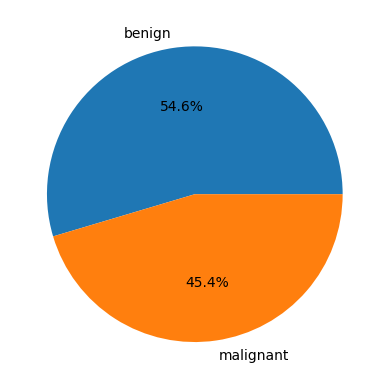

In [10]:
x = df['labels'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.1f%%')
plt.show()


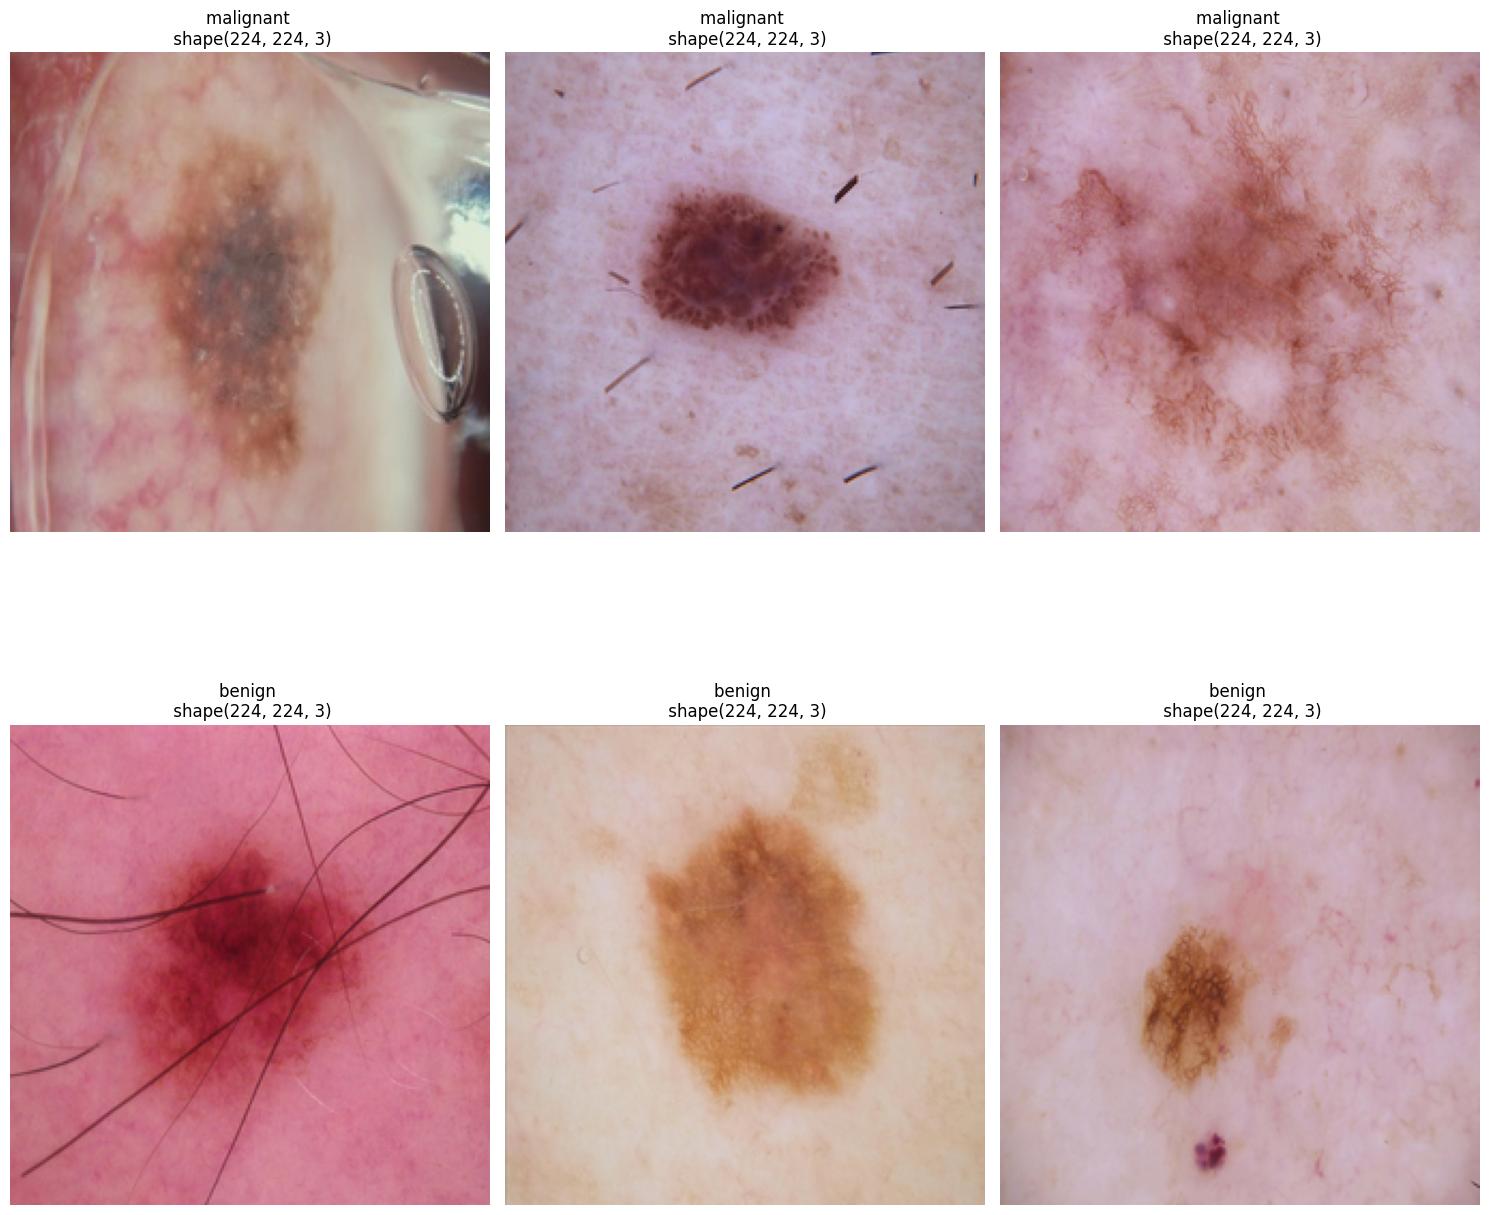

In [11]:
# display random images
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:

    img=df["images"][df["labels"]==label]
    select_images= random.choices(img.values,k=3)

    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

# **Image Preprocessing And Augmentation **

In [12]:
#data preprocessing and augmentation during training
#shear_range=0.2, This randomly applies a shearing transformation to the image.
#zoom_range=0.2, This randomly applies a zooming to the image.
#horizontal_flip=True, This randomly applies  a horizontal and vertical flip
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [13]:
# Load and preprocess training data
training_set = train_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/train',
                                                 target_size=(64,64),#resizes all images to a uniform size of 64x64 pixels.
                                                 batch_size=32,  #the number of images processed by the model at each training step
                                                 class_mode='binary')

# Load and preprocess test data
test_set = test_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/test',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [14]:
# the output  image shape  = (height,width,RGB)
training_set.image_shape

(64, 64, 3)

# Building CNN layers + NN

In [15]:
#define CNN layers
model=Sequential()

# Convolutional layers
model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))# defines a 2D convolutional layer with 64 filters of size 3x3.  specifies the expected input image shape (input_shape)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
model.add(Flatten())

#fully connected layers
model.add(Dense(units=128,activation="relu"))#Adds a fully connected layer with 128 neurons and ReLU activation
model.add (Dense(units=64,activation="relu"))
#model.(Dropout(0.3)
model.add(Dense(units=1,activation='sigmoid')) # #Adds the final output layer with 1 neuron and sigmoid activation (suitable for binary classification).

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

# **Train the model**


In [17]:
#step_per_epoch= 1440(number of data-train)/ 32 (batch-size)
history = model.fit(training_set,
                    steps_per_epoch=45,
                    epochs=25,
                    validation_data=test_set)

Epoch 1/25
45/45 [==============================] - 11s 108ms/step - loss: 0.6564 - accuracy: 0.5861 - val_loss: 0.6200 - val_accuracy: 0.7136
Epoch 2/25
45/45 [==============================] - 5s 101ms/step - loss: 0.5206 - accuracy: 0.7535 - val_loss: 0.5447 - val_accuracy: 0.7273
Epoch 3/25
45/45 [==============================] - 5s 113ms/step - loss: 0.5013 - accuracy: 0.7611 - val_loss: 0.4462 - val_accuracy: 0.7561
Epoch 4/25
45/45 [==============================] - 5s 105ms/step - loss: 0.4638 - accuracy: 0.7762 - val_loss: 0.4136 - val_accuracy: 0.7848
Epoch 5/25
45/45 [==============================] - 11s 238ms/step - loss: 0.4396 - accuracy: 0.7833 - val_loss: 0.3915 - val_accuracy: 0.7879
Epoch 6/25
45/45 [==============================] - 5s 111ms/step - loss: 0.4368 - accuracy: 0.7833 - val_loss: 0.4575 - val_accuracy: 0.7424
Epoch 7/25
45/45 [==============================] - 5s 105ms/step - loss: 0.4203 - accuracy: 0.7875 - val_loss: 0.4700 - val_accuracy: 0.7515
Epoc

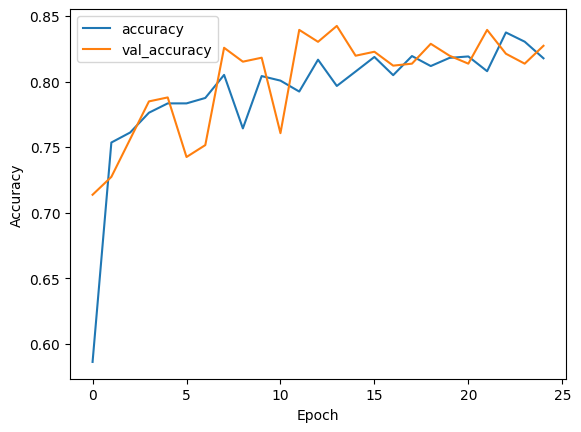

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Plot training history**

In [19]:
test_loss, test_acc = model.evaluate(test_set, steps=5)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


5/5 [==============================] - 0s 42ms/step - loss: 0.3571 - accuracy: 0.8000
Test accuracy: 0.800000011920929
Test loss: 0.3570657968521118


# Testing

In [20]:
from keras.preprocessing import image
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/54.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 [==============================] - 0s 337ms/step
The prediction result is: benign


In [21]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/b/18.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)#adds an extra dimension to the image array.

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 [==============================] - 0s 19ms/step
The prediction result is: benign


In [23]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/62.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)#adds an extra dimension to the image array.

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 [==============================] - 0s 20ms/step
The prediction result is: malignant


In [25]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/52.jpg"

# Print prediction result
print("The prediction result is:", prediction)


The prediction result is: malignant


In [27]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/1.jpg"

# Print prediction result
print("The prediction result is:", prediction)

The prediction result is: malignant


# Evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score

# Evaluate model performance
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print(classification_report(y_true, y_pred))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

# Print F1-score
print("F1-score:", f1_score(y_true, y_pred))

# Print precision
print("Precision:", precision_score(y_true, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))


21/21 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       360
           1       0.49      0.51      0.50       300

    accuracy                           0.54       660
   macro avg       0.54      0.54      0.54       660
weighted avg       0.54      0.54      0.54       660

[[202 158]
 [146 154]]
F1-score: 0.5032679738562091
Precision: 0.4935897435897436
Accuracy: 0.5393939393939394
